# Exercise: The Vertical Fault - Part 1
### Solution by Niels F. Nymand

In [1]:
import numpy as np
import matplotlib.pyplot as plt


import gravdata.txt to numpy array

((0.0, 41900.0, 1.2375848050000008e-09, 1.4433502929499998e-07), None)

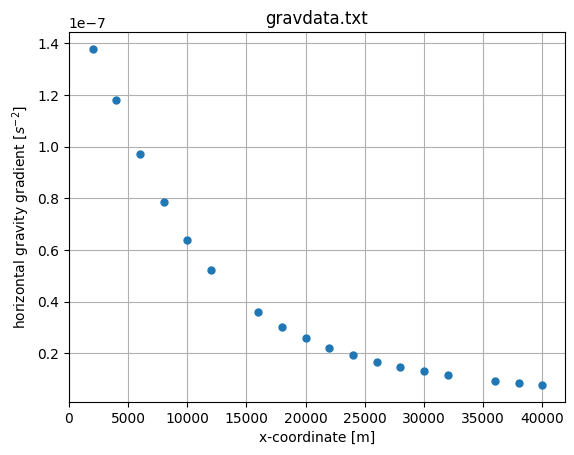

In [2]:
data = np.loadtxt('gravdata.txt')
xcoor = data[:,0]*1e3
d_obs = data[:,1]

plt.plot(xcoor,d_obs,'.',markersize=10)
plt.xlabel('x-coordinate [m]'),plt.ylabel(r'horizontal gravity gradient [$s^{-2}$]'),plt.title('gravdata.txt')
plt.axis([0,None,None,None]),plt.grid()

The relation between data point $d_j$ and the model parameter $\Delta\rho$ is given by,
$$ d_j = \frac{\partial g}{\partial x}(x_j) = \int_0^\infty \frac{2G_{grav}z}{x_j^2 + z^2}\Delta \rho(z)dz $$

where $G_{grav}$ is the gravitational constant $\left(=6.67\cdot 10^{-11} \frac{m^3}{kg\cdot s^2} \right) $, $x_j$ is the x coordinate of the gravity measurements.
## Discretization
We start by calculating the gravity gradient response from layer $i$, $d_j^{(i)}$. The layer is extending from $z=z_{base,i}$ to $z=z_{top,i}$ with constant density contrast $\Delta\rho(z) = \Delta\rho_i$.

$$ d_j^{(i)} = \int_{z_{top,i}}^{z_{base,i}} \frac{2G_{grav}z}{x_j^2 + z^2}\Delta \rho(z)dz = 2G_{grav}\Delta \rho_i \int_{z_{top,i}}^{z_{base,i}} \frac{z}{x_j^2 + z^2}dz = 2G_{grav}\Delta \rho \left[\frac{1}{2} \log\left(z^2+x_j^2\right) \right]_{z_{top,i}}^{z_{base,i}} $$

$$   d_j^{(i)} = G_{grav} \Delta \rho_i \log\left( \frac{z_{base,i}^2 + x_j^2 }{z_{top,i}^2 + x_j^2}  \right)  $$

The observation is a sum of all the layer contributions

$$ \boxed{  d_j = G_{grav} \sum_{i=1}^{M} \Delta \rho_i \log\left( \frac{z_{base,i}^2 + x_j^2 }{z_{top,i}^2 + x_j^2}  \right)  }$$

## Is the problem linear?

Lets see how the observables respond to a linear scaling of the density contrast, $\Delta\rho_i \rightarrow a\Delta\rho_i $

$$ G_{grav} \sum_{i=1}^{M} a\Delta \rho_i \log\left( \frac{z_{base,i}^2 + x_j^2 }{z_{top,i}^2 + x_j^2}  \right) = a G_{grav} \sum_{i=1}^{M} \Delta \rho_i \log\left( \frac{z_{base,i}^2 + x_j^2 }{z_{top,i}^2 + x_j^2}  \right) = \boxed{ad_j}  \checkmark$$

The problem can then be written on the form:
$$ \mathbf{d} = \mathbf{G}\mathbf{m} $$
where $\mathbf{d} = [d_1,d_2,\dots,d_N]^T $, $\mathbf{m} = [\Delta\rho_1,\Delta\rho_2,\dots,\Delta\rho_M]^T$ and $(\mathbf{G})_{j,i} = G_{grav}\log\left( \frac{z_{base,i}^2 + x_j^2 }{z_{top,i}^2 + x_j^2} \right)$

## Is the problem unique?
The number of data points $N=18$ is less than the number of model parameters $M=100$. The problem is therefor underdetermined, we have more model parameters than equations to constrain them. 
The solutions will therefore not be unique. Any solution from the null space $\mathbf{m}_{null}$ can be added to $\mathbf{m}$ without changing the observable.

$$ \mathbf{d} = \mathbf{G}(\mathbf{m} + a\mathbf{m}_{null}) = \mathbf{G}\mathbf{m} $$

## Finding a solution

We want to find a solution that explains data as good as possible, without fitting the noise. The problem with a underdetermined problem is that data can be explained perfectly, noise and all. This can lead to solutions that has little resemplance to the real physical world. 


Constructing the model matrix $\mathbf{G} $


In [3]:
M = 100  # number of layers, number of model parameters
N = d_obs.shape[0]

G_grav = 6.67e-11  # gravitational constant
dz = 1e3 # depth of each layer

z_top = np.arange(0,M*dz,dz)
z_base    = z_top + dz


G = np.zeros((N,M))

# fill in each row of G
for j in range(N):
    G[j,:] = G_grav*np.log( (z_base**2 + xcoor[j]**2)/(z_top**2 + xcoor[j]**2) )




We now have everything to calculate the forward problem
$$ \mathbf{d} = \mathbf{G}\mathbf{m} $$

The estimated solution, $\mathbf{m}^{est}$, to this problem can be formulated in a least squares sense

$$\boxed{ \mathbf{m}^{est} = \left[\mathbf{G}^T \mathbf{G} + \epsilon^2 \mathbf{I}\right]^{-1} \mathbf{G}^T \mathbf{d}^{obs}  }$$

which comes from minimizing the misfit function $L(\mathbf{m})$ 
$$ L(\mathbf{m}) = ||\mathbf{G}\mathbf{m}-\mathbf{d}^{obs}||^2 + \epsilon^2||\mathbf{m}||^2 = (\mathbf{G}\mathbf{m}-\mathbf{d}^{obs})^T(\mathbf{G}\mathbf{m}-\mathbf{d}^{obs}) + \epsilon^2\mathbf{m}^T\mathbf{m} $$
$$ \mathbf{m}^{est} = \arg\min_{\mathbf{m}} L(\mathbf{m}) $$


$\epsilon$ is trying to make sure that the solution stays smooth. But how large should $\epsilon $ be?

It seems resonable to adjust $\epsilon$ in such a way that the norm of the misfit is comparable to the norm of the noise.
Let $\mathbf{\eta}$ be a vector containing the standard deviation of each measurement in $\mathbf{d}^{obs}$

Then we wish to pick a $\epsilon$ that satisfies
$$ ||\mathbf{G}\mathbf{m}^{est}-\mathbf{d}^{obs}||^2 \approx ||\mathbf{\eta}||^2 $$
And in this example the standard deviation of all the datapoints are equal, $||\mathbf{\eta} ||^2 = N\sigma^2 $

In [4]:
def lsqr_solution(G,d,epsilon):
    '''Calculates the damped least squares solution with damping coefficient epsilon'''
    N,M = G.shape
    eye = np.diag(np.ones(M)) # creating the identity matrix
    
    # A = G.TG + epsilon^2 I
    A = np.dot(G.T,G) + epsilon**2 * eye
    Ainv = np.linalg.inv(A)
    
    m = np.dot(np.dot(Ainv,G.T),d)
    return m

def residual(d,G,m):
    '''Calculates the squared norm of the residual'''
    d_est = np.dot(G,m)
    return np.linalg.norm(d-d_est)**2




 Chosen epsilon = 6.309218436873748e-12
 Minimum difference = 1.1979166598566081e-22
 Minimum residual = 1.800011979166599e-17
[[1.48836749e-11 3.13492421e-11 3.23833713e-11 ... 1.36764163e-12
  1.35376820e-12 1.34017331e-12]
 [4.04366228e-12 1.08400126e-11 1.48836749e-11 ... 1.36591804e-12
  1.35209651e-12 1.33855145e-12]
 [1.82751158e-12 5.20003482e-12 7.85612848e-12 ... 1.36305503e-12
  1.34931952e-12 1.33585706e-12]
 ...
 [5.14462039e-14 1.54100954e-13 2.56046380e-13 ... 1.20405954e-12
  1.19473122e-12 1.18551774e-12]
 [4.61751490e-14 1.38333959e-13 2.29920945e-13 ... 1.18778537e-12
  1.17886709e-12 1.17005072e-12]
 [4.16744781e-14 1.24867431e-13 2.07594316e-13 ... 1.17110108e-12
  1.16259524e-12 1.15417862e-12]]


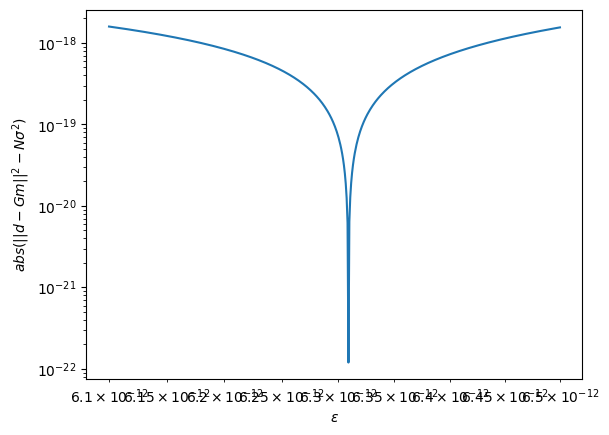

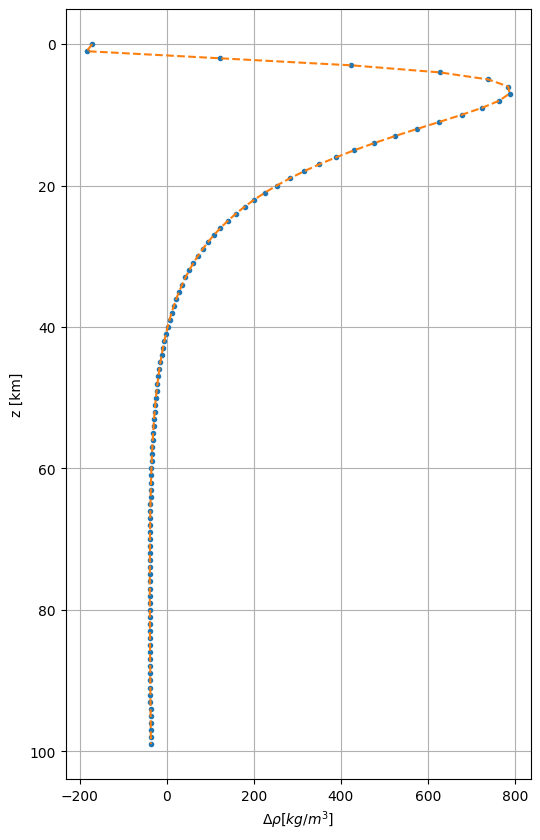

In [5]:
sigma = 1e-9
norm_noise = N*sigma**2


#epsilons = np.logspace(-12,-10,500) # use this to try an narrow down the search
epsilons = np.linspace(6.1e-12,6.5e-12,num=500) #use this to more accuratly locate the minimum
difference = np.zeros_like(epsilons)

for i in range(len(epsilons)):
    m_est = lsqr_solution(G,d_obs,epsilons[i])
    difference[i] = np.abs( residual(d_obs,G,m_est) - norm_noise )


epsi = epsilons[difference == np.min(difference)][0]
plt.loglog(epsilons,difference)
plt.xlabel(r'$\epsilon$'),plt.ylabel(r'$abs( ||d-Gm||^2-N\sigma^2 )$')


m_est = lsqr_solution(G,d_obs,epsi)

print(f' Chosen epsilon = {epsi}\n Minimum difference = {np.min(difference)}\n Minimum residual = {np.min(difference)+norm_noise}')

#plt.imshow(m_est.reshape((100,1)),aspect='auto'),plt.colorbar()
plt.figure(figsize=(6,10))
plt.plot(m_est,z_top/1e3,'.')
plt.plot(m_est,z_top/1e3,'--')
plt.xlabel(r'$\Delta\rho [kg/m^3]$'),plt.ylabel('z [km]')
plt.gca().invert_yaxis()
plt.grid()

print(G)

In [6]:
def h_to_z(h):
    z = np.zeros(101)
    for i in range(len(h)+1):
        z[i] = np.sum(h[:i])
    return z

def gravfunction(m):
    z = h_to_z(m[0:100])
    print(z)
    d_est = np.zeros_like(d_obs)
    for i in range(len(d_est)):
        for j in range(int(len(m)/2)):
            d_est[i] += m[j+100]*G_grav*np.log((z[j+1]**2+xcoor[i]**2)/(z[j]**2+xcoor[i]**2))
    return d_est

m = np.ones(100)*1000
m = np.concatenate((m,m_est))
print(gravfunction(m))
print(d_obs)
print(np.matmul(G,m_est))

[     0.   1000.   2000.   3000.   4000.   5000.   6000.   7000.   8000.
   9000.  10000.  11000.  12000.  13000.  14000.  15000.  16000.  17000.
  18000.  19000.  20000.  21000.  22000.  23000.  24000.  25000.  26000.
  27000.  28000.  29000.  30000.  31000.  32000.  33000.  34000.  35000.
  36000.  37000.  38000.  39000.  40000.  41000.  42000.  43000.  44000.
  45000.  46000.  47000.  48000.  49000.  50000.  51000.  52000.  53000.
  54000.  55000.  56000.  57000.  58000.  59000.  60000.  61000.  62000.
  63000.  64000.  65000.  66000.  67000.  68000.  69000.  70000.  71000.
  72000.  73000.  74000.  75000.  76000.  77000.  78000.  79000.  80000.
  81000.  82000.  83000.  84000.  85000.  86000.  87000.  88000.  89000.
  90000.  91000.  92000.  93000.  94000.  95000.  96000.  97000.  98000.
  99000. 100000.]
[1.38991606e-07 1.17024858e-07 9.46434693e-08 7.66773460e-08
 6.27354289e-08 5.18968923e-08 3.66094325e-08 3.11571006e-08
 2.67180307e-08 2.30668105e-08 2.00357835e-08 1.74985863e

## Can we say anything about the quality of this solution?

We can calculate the resolution matrix, which is used to give the resolution of the inverse operator.
let $\mathbf{G}_{inv} = \left[\mathbf{G}^T \mathbf{G} + \epsilon^2 \mathbf{I}\right]^{-1} \mathbf{G}^T $
$$ \mathbf{m}^{est} = \mathbf{G}_{inv} \mathbf{d}^{obs} = \mathbf{G}_{inv} \left[ \mathbf{G}\mathbf{m}^{true}\right] = \left[\mathbf{G}_{inv} \mathbf{G}\right] \mathbf{m}^{true} = \mathbf{R}\mathbf{m}^{true} $$

$$ \mathbf{R} = \left[\mathbf{G}^T \mathbf{G} + \epsilon^2 \mathbf{I}\right]^{-1} \mathbf{G}^T \mathbf{G} $$

When we know the uncertainty of the data we can estimate the uncertanity of the estimated model.
This can be done by using the data covariance matrix, $\mathbf{C}_d = \sigma^2\mathbf{I}$: 

$$ \mathbf{C}_m = \mathbf{G}_{inv}\mathbf{C}_d\mathbf{G}_{inv}^T $$

(Text(0.5, 0, '$i$'), Text(0, 0.5, '$\\sigma_{m_i}$'))

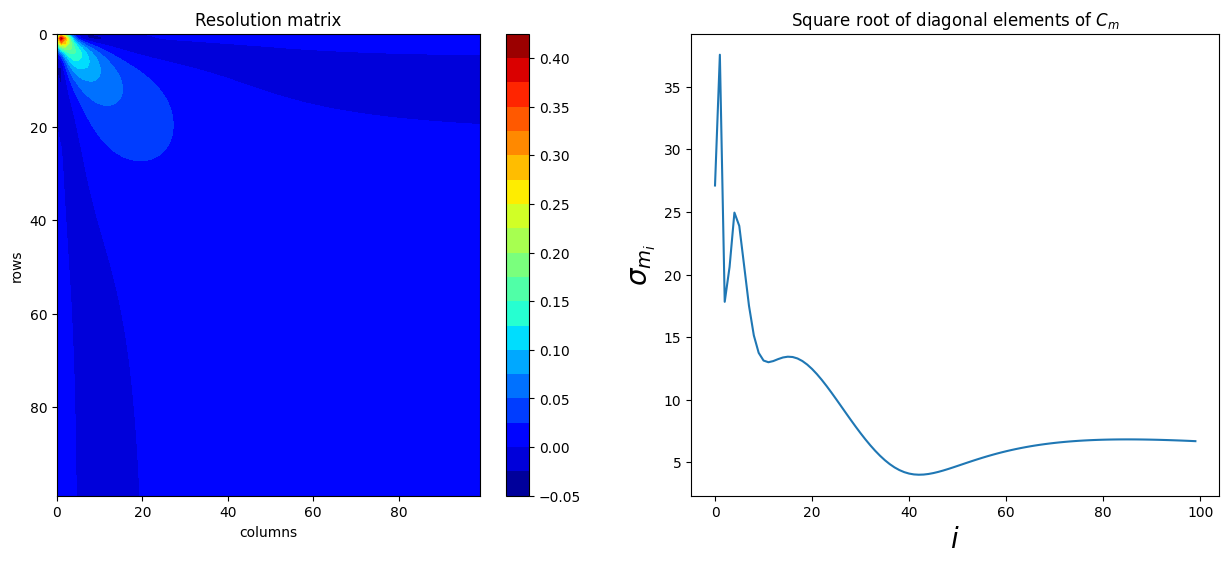

In [7]:
A = np.dot(G.T,G) + epsi**2 * np.diag(np.ones(M))
Ginv = np.dot(np.linalg.inv(A),G.T)

R  = np.dot(Ginv,G)

C_d = sigma**2 * np.diag(np.ones(N))
C_m = np.dot(Ginv,np.dot(C_d,Ginv.T))

#C_m = sigma**2*Ginv

sigma_m = np.sqrt(np.diag(C_m) )

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.contourf(R,levels=20,cmap='jet'),plt.colorbar(),plt.axis([0,M-1,M-1,0]),plt.title('Resolution matrix'),plt.xlabel('columns'),plt.ylabel('rows')
plt.subplot(1,2,2)
plt.plot(sigma_m   ),plt.title(r'Square root of diagonal elements of $C_m$')#,plt.axis([None,None,0,40])
plt.xlabel(r'$i$',fontsize=20),plt.ylabel(r'$\sigma_{m_i}$',fontsize=20)

### plotting the solution with errorbars

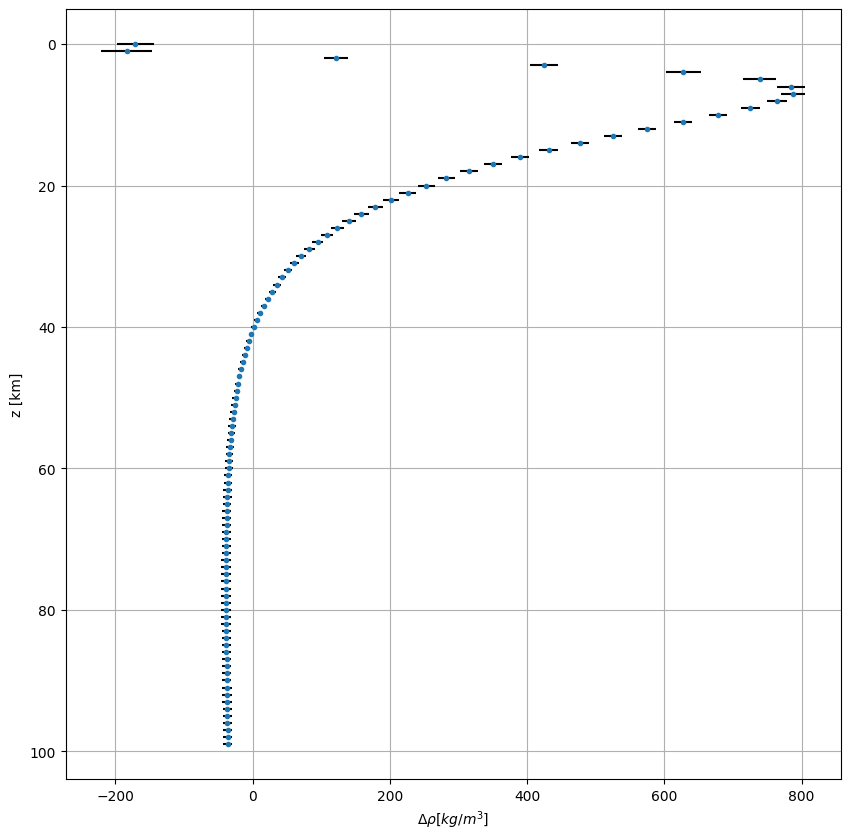

In [8]:
plt.figure(figsize=(10,10))
plt.errorbar(m_est,z_top/1e3,xerr = sigma_m,ecolor='k',fmt='.' )
plt.xlabel(r'$\Delta\rho [kg/m^3]$'),plt.ylabel('z [km]')
plt.gca().invert_yaxis()
plt.grid()

Comparing the estimated data with the observed data

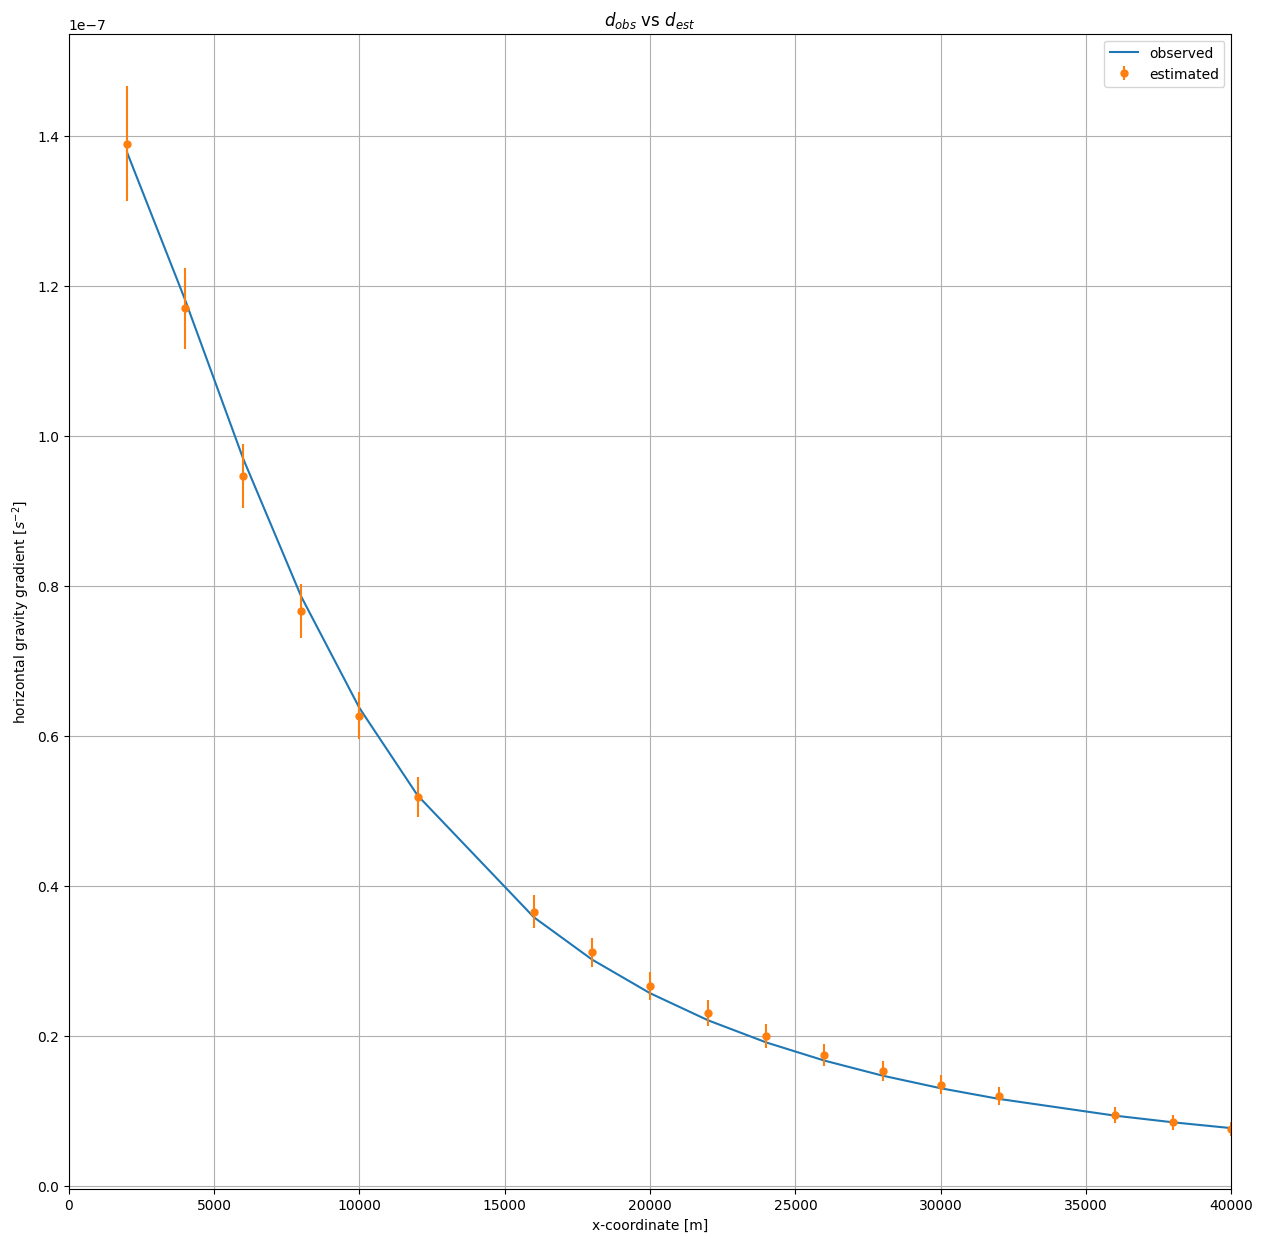

In [9]:
d_est = np.dot(G,m_est)

plt.figure(figsize=(15,15))
plt.plot(xcoor,d_obs,label='observed')
plt.errorbar(xcoor,d_est,yerr=np.dot(G,sigma_m ),fmt='.',markersize=10,label='estimated' )
plt.xlabel('x-coordinate [m]'),plt.ylabel(r'horizontal gravity gradient [$s^{-2}$]'),plt.title(r'$d_{obs}$ vs $d_{est}$')
plt.axis([0,xcoor[-1]+1,None,None]),plt.grid()
plt.legend()

